<code>calculate_error_propagation_S2S_models_VRILE_days.ipynb</code>.  We calculate the error propagation that occurs during/after VRILE days

<b>inputs:</b><br>
<li>  model name (ecmwf,ukmo,ncep,metreofr) </li>
<li>  seas_str [string for season; ALL if we want to do full year]</li>
<li>  seas_sel [months of season; empty if we want to do full year] </li>
<li>  vrile_thresh [threshhold at which VRILE is estimated </li>
<li>  thresh_str [string for VRILE threshhold] </li>


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

## Functions

<li>1) Load model netCDF files, combine with CTRL, and use common reforecast period. <br>
if NCEP, use entire period </li>
<li> 2) Add aggregate regions </li>
<li> 3) Create climatology--model: calculate date of year for valid date, lead time in weeks.<br>
    Group by region, lead time, and valid date of year <br>
    Average climatology based on day of year and lead time in weeks--use <code>transform</code> to create <code>SIE_clim</code>.<br> 
    Subtract <code>SIE_clim</code> from <code>SIE</code><br> </li>
<li> 4) Create observed climatology </li>
<li> 5) Identify VRILE days </li>
<li> 6) Shift VRILE days, if we want to start prediction before the VRILE (shift by 0 if we want to start on the VRILE day) </li>
<li> 7) Identify model forecasts that start on day/week 0 of event (i.e., if VRILE starts on July 10, and we want to start predicting 7 days before the VRILE started, look for model forecasts that initialize within 1 day/week of July 3) </li>
<li> 8) Calculate errors: as a function of region, valid date, and lead time. Want to output: <br>
    Raw error (for bias) <br>
    Mean absolute error <br>
    RMSE <br>
    For both SIE and anomalous SIE </li>

Load the netCDF files for our specific model from <code>/home/disk/sipn/nicway</code>.  We want the control runs too.  Then, select only the common reforecast period (1999-01-01 to 2014-12-31), and add the control run to the rest of the output. <br>
NOTE: for NCEP, since the reforecast period is short (ends in 2011), we will just use the entire period. 

In [2]:
def load_model(model_name):
    # Paths for perturb and control runs
    filepath = '/home/disk/sipn/nicway/data/model/{model_name}/reforecast/sipn_nc_agg/'.format(model_name=model_name)
    filepath_ctrl = '/home/disk/sipn/nicway/data/model/{model_name}/reforecast.control/sipn_nc_agg/'.format(model_name=model_name)
    # Open both with xarray
    filenames = xr.open_mfdataset(filepath+'/*.nc',combine='by_coords')
    filenames_ctrl = xr.open_mfdataset(filepath_ctrl+'/*.nc',combine='by_coords')
    print(filenames)
    # load SIE
    SIE = filenames.Extent
    SIE_ctrl = filenames_ctrl.Extent
    # Add coordinate to ensemble dimension for SIE_ctrl so we can combine with SIE
    SIE_ctrl.coords['ensemble'] = xr.DataArray([len(SIE.ensemble)],
                                               dims='ensemble', coords={'ensemble':[len(SIE.ensemble)]})
    # Use common reforecast period for all models EXCEPT NCEP
    if model_name == 'ncep':
        # Don't need to use a common reforecast but remove repeated indices
        _,init_ind = np.unique(SIE['init_time'],return_index=True)
        _,init_ind_c = np.unique(SIE_ctrl['init_time'],return_index=True)
        SIE = SIE.isel(init_time=init_ind)
        SIE_ctrl = SIE_ctrl.isel(init_time=init_ind_c)
    elif model_name != 'ncep':
        common_start = '1999-01-01'
        common_end = '2014-12-31'
        # Select only common reforecast period (full period for NCEP)
        SIE = SIE.sel(init_time=slice(common_start,common_end))
        SIE_ctrl = SIE_ctrl.sel(init_time=slice(common_start,common_end))
        # Remove repeated indices in CTRL
        _,init_ind_c = np.unique(SIE_ctrl['init_time'],return_index=True)
        SIE_ctrl = SIE_ctrl.isel(init_time=init_ind_c)
    # Concatenate the two
    SIE = xr.concat([SIE,SIE_ctrl],dim='ensemble')
    
    return SIE

We want to create a few aggregate regions from the NSIDC MASIE regions (more at: https://nsidc.org/data/masie/browse_regions) since some regions are so small. We're going to combine the following: <br>
<li> Kara and Laptev Seas (<code>region_KL</code>)</li>
<li> Barents, Kara and Laptev Seas (<code>region_BKL</code>)</li>
<li> East Siberian, Beaufort, and Chukchi Seas (<code>region_EBC</code>)</li>
<li> Atlantic (Baffin Bay and East Greenland Sea) (<code>region_ATL</code>)</li>
<li> East Siberian, Beaufort, Chukchi, Laptev Seas (<code>region_EBCL</code>)</li>


In [3]:
def create_aggregate_regions(SIE_data):
    nregions = SIE_data['nregions']
    region_names = SIE_data['region_names']
    # Get corresponding indices for each of our aggregate regions
    region_KL = nregions[region_names.isin(['Kara Sea','Laptev Sea'])]
    region_BKL = nregions[region_names.isin(['Barents Sea','Kara Sea','Laptev Sea'])]
    region_EBC = nregions[region_names.isin(['East Siberian Sea','Beaufort Sea','Chukchi Sea'])]
    region_ATL = nregions[region_names.isin(['Baffin Bay','East Greenland Sea'])]
    region_EBCL = nregions[region_names.isin(['East Siberian Sea','Beaufort Sea','Chukchi Sea','Laptev Sea'])]
    # Select each aggregate region, add them together, and add the 'nregions' dimension back; concatenate all aggregates 
    SIE_agg = xr.concat([SIE_data.sel(nregions=region_KL).sum(dim='nregions').expand_dims(dim='nregions'),
                  SIE_data.sel(nregions=region_BKL).sum(dim='nregions').expand_dims(dim='nregions'),
                  SIE_data.sel(nregions=region_EBC).sum(dim='nregions').expand_dims(dim='nregions'),
                  SIE_data.sel(nregions=region_ATL).sum(dim='nregions').expand_dims(dim='nregions'),
                  SIE_data.sel(nregions=region_EBCL).sum(dim='nregions').expand_dims(dim='nregions')],dim='nregions')
    # Add coordinates to nregions.  Start at 20 to make a clear separation from original NSIDC regions
    SIE_agg = SIE_agg.assign_coords(nregions=[20,21,22,23,24])
    # Add region names
    region_names_extra = ['Kara-Laptev Sea','Barents-Kara-Laptev Sea','East Siberian-Beaufort-Chukchi Sea',
                      'Atlantic','East Siberian-Beaufort-Chukchi-Laptev Sea']
    SIE_agg["region_names"] = ("nregions",region_names_extra)
    #SIE
    SIE_data = xr.concat([SIE_data,SIE_agg],dim='nregions')
    return(SIE_data)

Create climatology for model output based on region, day of year, and lead time.  Get month-day for valid dates (don't use dayofyear because of leap days).  Since our forecasts are not initialized every day, we will do two versions--one where we keep each lead time separate, and one where we group our lead time climatology based on week instead of day (which is more supported in the literature). 

In [4]:
def create_model_climatology(SIE,week_length):
    # Add valid date in %m-%d format
    SIE['valid date of yr'] = pd.to_datetime(SIE['valid date']).dt.strftime('%m-%d')
    # Determine lead time as a function of weeks instead of days
    SIE_df_weekly = SIE.copy()
    SIE_df_weekly['lead time (weeks)'] = SIE_df['lead time (days)'].values.astype('timedelta64[D]')/pd.Timedelta(week_length,'D')
    SIE_df_weekly['lead time (weeks)'] = SIE_df_weekly['lead time (weeks)'].apply(np.floor)
    # Group by region, lead time, and valid day of year. Use .transform('mean') so that our climatology has the 
    # same shape as the original input dataframe (so we can just subtract SIE_clim from SIE easily at the end)
    SIE['SIE clim'] = SIE.groupby(['region','lead time (days)','valid date of yr'])['SIE'].transform('mean')
    SIE_df_weekly['SIE clim'] = SIE_df_weekly.groupby(['region','lead time (weeks)','valid date of yr'])['SIE'].transform('mean')

    SIE['SIE anom'] = SIE['SIE'] - SIE['SIE clim']
    SIE_df_weekly['SIE anom'] = SIE_df_weekly['SIE'] - SIE_df_weekly['SIE clim']
    return(SIE,SIE_df_weekly)

Create climatology for the observations.  This is easier, we just need to get the day of year (month-day) for each observation, take the mean, and then subtract the annual cycle from our full dataset. 

In [5]:
def create_obs_climatology(SIE):
    # Add valid date in %m-%d format
    SIE['valid day of year'] = pd.to_datetime(SIE['valid date']).dt.strftime('%m-%d')
    # Group by region and day of year and take the mean. Use transform to make the output match the dataframe instead
    # of creating a multi-index
    SIE['SIE clim'] = SIE.groupby(['region','valid day of year'])['SIE'].transform('mean')
    # And simply subtract SIE_clim from actual SIE
    SIE['SIE anom'] = SIE['SIE'] - SIE['SIE clim']
    return SIE

Calculate VRILE days from obs.  Determine $n$-day changes in SIE and anomalous SIE, and estimate the lower tail of the distribution based on <code>VRILE_thresh</code>.  For now, we'll assume we need a 5-day change in SIE.  

In [6]:
def get_VRILE_days(obs_SIE,vrile_thresh,nday_change,seas_sel):
    # Use shift to move SIE/SIE anom foreward and backward by nday_change days
    nday_shift = np.floor(nday_change/2)
    obs_SIE['SIE anom -n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(-nday_shift)
    obs_SIE['SIE anom +n'] = obs_SIE.groupby(['region'])['SIE anom'].shift(+nday_shift)
    obs_SIE['SIE -n'] = obs_SIE.groupby(['region'])['SIE'].shift(-nday_shift)
    obs_SIE['SIE +n'] = obs_SIE.groupby(['region'])['SIE'].shift(+nday_shift)
    obs_SIE['d_SIE'] = obs_SIE['SIE -n'] - obs_SIE['SIE +n']
    obs_SIE['d_SIE anom'] = obs_SIE['SIE anom -n'] - obs_SIE['SIE anom +n']
    # Trim to correct season based on seas_sel
    if not seas_sel:
        obs_SIE = obs_SIE
    else:
        obs_SIE = obs_SIE[pd.to_datetime(obs_SIE['valid date']).dt.month.isin(seas_sel)]
    # Identify VRILE days based on vrile_thresh
    obs_SIE['SIE p05'] = obs_SIE.groupby(['region'])['d_SIE'].transform(lambda x: x.quantile(vrile_thresh))
    obs_SIE['SIE anom p05'] = obs_SIE.groupby(['region'])['d_SIE anom'].transform(lambda x: x.quantile(vrile_thresh))
    obs_SIE_VRILE_only = obs_SIE.groupby(['region']).apply(lambda x: x[x['d_SIE'] <= x['SIE p05']])
    obs_SIE_anom_VRILE_only = obs_SIE.groupby(['region']).apply(lambda x: x[x['d_SIE anom'] <= x['SIE anom p05']])
    # Also return non-VRILE days only
    obs_SIE_NO_VRILE = obs_SIE.groupby(['region']).apply(lambda x: x[x['d_SIE'] > x['SIE p05']])
    obs_SIE_anom_NO_VRILE = obs_SIE.groupby(['region']).apply(lambda x: x[x['d_SIE anom'] > x['SIE anom p05']])
    # Keep only VRILE days
    obs_SIE_VRILE_only = obs_SIE_VRILE_only.reset_index(level=0, drop=True).reset_index()
    obs_SIE_anom_VRILE_only = obs_SIE_anom_VRILE_only.reset_index(level=0, drop=True).reset_index()
    obs_SIE_NO_VRILE = obs_SIE_NO_VRILE.reset_index(level=0,drop=True).reset_index()
    obs_SIE_anom_NO_VRILE = obs_SIE_anom_NO_VRILE.reset_index(level=0,drop=True).reset_index()
    return obs_SIE_VRILE_only, obs_SIE_anom_VRILE_only, obs_SIE_NO_VRILE, obs_SIE_anom_NO_VRILE

Calculate raw error, mean absolute error, and RMSE.  These calculations will be a function of region and lead time.  See nice notebook for equations for RMSE and MAE

In [117]:
def calculate_errors(model_SIE,obs_SIE):
    # Group by region, valid date, and lead time (for model)
    SIE_obsx = obs_SIE.groupby(['region','valid date'])['SIE','SIE clim','SIE anom'].mean()
    # First calculate raw model error (we'll also group by init time so we can save that for calculating other stuff)
    SIE_model_raw = model_SIE.groupby(['region','valid date','lead days','init date'])['SIE','SIE clim','SIE anom'].mean()
    SIE_raw_error = SIE_model_raw[['SIE','SIE anom']] - SIE_obsx[['SIE','SIE anom']]
    SIE_raw_error = SIE_raw_error.dropna(how='all')
    # Now, we'll do MAE and RMSE (we don't care about the date of initialization)
    SIE_modelx = model_SIE.groupby(['region','valid date','lead days'])['SIE','SIE clim','SIE anom'].mean()
    SIE_diff = SIE_modelx[['SIE','SIE anom']] - SIE_obsx[['SIE','SIE anom']]
    # Square errors to get RMSE. get absolute value of errors for MAE
    SIE_diff = SIE_diff#.dropna(how='all')
    SIE_diff = SIE_diff.rename(columns={'SIE':'SIE raw error','SIE anom':'SIE anom raw error'})
    SIE_diff[['SIE sq error','SIE anom sq error']] = SIE_diff**2
    # Now, average over all valid dates and take the square root. 
    SIE_errors = np.sqrt(SIE_diff[['SIE sq error','SIE anom sq error']].mean(level=(0,2)))
    # Absolute value, then average over all valid dates to get the MAE
    SIE_errors[['SIE MAE','SIE anom MAE']] = SIE_diff[['SIE raw error','SIE anom raw error']].abs().mean(level=(0,2))
    SIE_errors = SIE_errors.rename(columns={'SIE sq error':'SIE RMSE','SIE anom sq error':'SIE anom RMSE'})
    return(SIE_raw_error,SIE_errors)
    

In [298]:
model_name = 'ukmo'
seas_str = 'ALL'
seas_sel = [1,2,3,4,5,6,7,8,9,10,11,12]
obs_name = 'NSIDC_0079'
WEEKLY = True
lead_weeks = True
vrile_thresh = 0.1
thresh_str = '10'
nday_change = 5 #number of days for VRILE calculation
normalize = False
VRILE_shift = 14 # days; number of days BEFORE VRILE to analyze
COMMON_RF = True
max_date_offset = 7 # days; number of days +/- the start of the VRILE

Load model output for our desired model

In [299]:
SIE = load_model(model_name)
print('loaded ',model_name)

<xarray.Dataset>
Dimensions:       (ensemble: 6, fore_time: 60, init_time: 1008, nregions: 15)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * ensemble      (ensemble) int32 0 1 2 3 4 5
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * fore_time     (fore_time) timedelta64[ns] 0 days 1 days ... 58 days 59 days
  * init_time     (init_time) datetime64[ns] 1995-01-01 ... 2015-12-25
Data variables:
    Extent        (ensemble, init_time, fore_time, nregions) float64 dask.array<chunksize=(6, 1, 60, 15), meta=np.ndarray>
<xarray.Dataset>
Dimensions:       (ensemble: 6, fore_time: 60, init_time: 1008, nregions: 15)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * ensemble      (ensemble) int32 0 1 2 3 4 5
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * fore_time     (fore_time) timedelta64[ns] 0 days 1 days ... 58 days 59 days
  * init_time 

Create aggregate regions that combine some of the NSIDC-MASIE regions

In [300]:
SIE = create_aggregate_regions(SIE)
print('combined regions')

combined regions
combined regions


Now, take the ensemble mean and get lead time in days

In [301]:
SIE_ens_mean = SIE.mean(dim='ensemble')
regions = SIE.region_names
lead_days = SIE.fore_time.dt.days

Convert to dataframe because I like Pandas

In [302]:
SIE_df = SIE_ens_mean.to_dataframe().reset_index()

Calculate the date for forecasts by adding the <code>fore_time</code> to <code>init_time</code>. Rename some columns to make life easier

In [303]:
SIE_df['valid date'] = SIE_df['init_time'] + SIE_df['fore_time']
SIE_df = SIE_df.rename(columns={'region_names':'region',
                           'fore_time':'lead time (days)',
                           'init_time':'init date',
                           'Extent':'SIE'})

Create climatology for model output.  Decide how long we want weeks to be for weekly climatology (default is 7 days)

In [304]:
week_length = 7
SIE_df,SIE_df_weekly = create_model_climatology(SIE_df,7)
print('model climatology created')

model climatology created
model climatology created


Load observations.  NSIDC_0079 is NASA Bootstrap, NSIDC_0081 is NASA team

In [305]:
obs_type = 'sipn_nc_yearly_agg'
filepath = '/home/disk/sipn/nicway/data/obs/{model_name}/{model_type}/'.format(model_name=obs_name,
                                                                              model_type=obs_type)
obs_filenames = xr.open_mfdataset(filepath+'/*.nc',combine='by_coords')
print('opening ',obs_filenames)
obs_SIE = obs_filenames.Extent
obs_regions = obs_filenames.nregions
obs_region_names = obs_filenames['region_names'].values
# Drop region names and re-add as a non-dask.array object.  This is stupid but oh well
obs_SIE = obs_SIE.drop('region_names')
obs_SIE["region_names"] = ("nregions",obs_region_names)
print('obs loaded')

opening  <xarray.Dataset>
Dimensions:       (nregions: 15, time: 11322)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * time          (time) datetime64[ns] 1989-01-01 1989-01-02 ... 2019-12-31
Data variables:
    Extent        (time, nregions) float64 dask.array<chunksize=(365, 15), meta=np.ndarray>
obs loaded
opening  <xarray.Dataset>
Dimensions:       (nregions: 15, time: 11322)
Coordinates:
    region_names  (nregions) object dask.array<chunksize=(15,), meta=np.ndarray>
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * time          (time) datetime64[ns] 1989-01-01 1989-01-02 ... 2019-12-31
Data variables:
    Extent        (time, nregions) float64 dask.array<chunksize=(365, 15), meta=np.ndarray>
obs loaded


Add aggregate regions to obs and convert obs to Pandas dataframe

In [306]:
obs_SIE = create_aggregate_regions(obs_SIE)
obs_SIE = obs_SIE.to_dataframe().reset_index()
obs_SIE = obs_SIE.rename(columns={'Extent':'SIE','region_names':'region','time':'valid date'})

Calculate our observed climatology 

In [307]:
if COMMON_RF == True:
    obs_SIE = obs_SIE[pd.to_datetime(obs_SIE['valid date']).dt.year.isin(np.arange(1999,2015))]
    obs_SIE = create_obs_climatology(obs_SIE)
    time_str = 'COMMON_RF'
    print('common reforecast')
else:
    time_str = 'FULL_PERIOD'
    obs_SIE = create_obs_climatology(obs_SIE)
    print('full period')
print('observed climatology created')

common reforecast
observed climatology created
common reforecast
observed climatology created


Estimate observed VRILE days

In [308]:
obs_SIE_VRILE_onlyx, obs_SIE_anom_VRILE_onlyx, obs_SIE_NO_VRILEx, obs_SIE_anom_NO_VRILEx = get_VRILE_days(obs_SIE,vrile_thresh,nday_change,seas_sel)
print('VRILE days calculated')

VRILE days calculated
VRILE days calculated


Index with region

In [309]:
obs_SIE_VRILE_only = obs_SIE_VRILE_onlyx.set_index(['region'])
obs_SIE_anom_VRILE_only = obs_SIE_anom_VRILE_onlyx.set_index(['region'])
#
obs_SIE_NO_VRILE = obs_SIE_NO_VRILEx.set_index(['region'])
obs_SIE_anom_NO_VRILE = obs_SIE_anom_NO_VRILEx.set_index(['region'])


Day we START our predictions is determined by <code>VRILE_shift</code>

In [310]:
obs_SIE_VRILE_only['valid date START'] = obs_SIE_VRILE_only['valid date'] - pd.Timedelta(VRILE_shift,'D')
obs_SIE_anom_VRILE_only['valid date START'] = obs_SIE_anom_VRILE_only['valid date'] - pd.Timedelta(VRILE_shift,'D')

Now, we find model forecasts that start within 3 days of <code>valid date START</code>

In [329]:
SIE_df['lead time (weeks)'] = np.floor(SIE_df['lead time (days)'].dt.days/week_length)
SIE_df_reg = SIE_df.set_index(['region'])
#x_reg = 'panArctic'
region_list = obs_SIE['region'].unique().tolist()
SIE_VRILES = pd.DataFrame()
obs_VRILES = pd.DataFrame()
SIE_no_VRILES = pd.DataFrame()
obs_no_VRILES = pd.DataFrame()
# Same, but for VRILES based on anomalous SIE
SIE_anom_VRILES = pd.DataFrame()
obs_anom_VRILES = pd.DataFrame()
SIE_anom_no_VRILES = pd.DataFrame()
obs_anom_no_VRILES = pd.DataFrame()
for x_reg in region_list:
    #SIE_df_x = SIE_df.set_index(['region']).xs((x_reg))
    dates_shifted = pd.DataFrame()
    dates_shifted['region'] = x_reg
    dates_shifted = pd.DataFrame(obs_SIE_VRILE_only.xs(x_reg)['valid date START'])
    dates_shifted_list = pd.DataFrame(obs_SIE_VRILE_only.xs(x_reg)['valid date START'])
    # Anom dates shifted
    anom_dates_shifted = pd.DataFrame()
    anom_dates_shifted['region'] = x_reg
    anom_dates_shifted = pd.DataFrame(obs_SIE_anom_VRILE_only.xs(x_reg)['valid date START'])
    anom_dates_shifted_list = pd.DataFrame(obs_SIE_anom_VRILE_only.xs(x_reg)['valid date START'])
    #
    for i in np.arange(1,max_date_offset+1):
        i_forward = dates_shifted + pd.Timedelta(i,'D')
        i_backward = dates_shifted - pd.Timedelta(i,'D')
        dates_shifted_list = dates_shifted_list.append((i_forward,i_backward))
        # same but for anom
        i_anom_forward = anom_dates_shifted + pd.Timedelta(i,'D')
        i_anom_backward = anom_dates_shifted - pd.Timedelta(i,'D')
        anom_dates_shifted_list = anom_dates_shifted_list.append((i_anom_forward,i_anom_backward)) 
    #dates_shifted_list_ALL = dates_shifted_list_ALL.append(dates_shifted_list)
    x_SIE = SIE_df_reg.loc[x_reg]
    x_SIE_VRILES = x_SIE[x_SIE['init date'].isin(dates_shifted_list['valid date START'])]
    x_obs = obs_SIE.set_index('region').loc[x_reg]
    x_SIE_obs = x_obs[x_obs['valid date'].isin(x_SIE_VRILES['valid date'])]
    SIE_VRILES = SIE_VRILES.append(x_SIE_VRILES)
    obs_VRILES = obs_VRILES.append(x_SIE_obs)
    #
    x_SIE_no = x_SIE[~x_SIE['init date'].isin(dates_shifted_list['valid date START'])]
    SIE_no_VRILES = SIE_no_VRILES.append(x_SIE_no)
    x_no_obs = x_obs[x_obs['valid date'].isin(x_SIE_no['valid date'])]
    obs_no_VRILES = obs_no_VRILES.append(x_no_obs)
    ### Same, but for anom
    x_anom_SIE_VRILES = x_SIE[x_SIE['init date'].isin(anom_dates_shifted_list['valid date START'])]
    #x_anom_obs = obs_SIE.set_index('region').loc[x_reg]
    x_anom_SIE_obs = x_obs[x_obs['valid date'].isin(x_anom_SIE_VRILES['valid date'])]
    SIE_anom_VRILES = SIE_anom_VRILES.append(x_anom_SIE_VRILES)
    obs_anom_VRILES = obs_anom_VRILES.append(x_anom_SIE_obs)
    #
    x_anom_SIE_no = x_SIE[~x_SIE['init date'].isin(anom_dates_shifted_list['valid date START'])]
    SIE_anom_no_VRILES = SIE_anom_no_VRILES.append(x_anom_SIE_no)
    x_anom_no_obs = x_obs[x_obs['valid date'].isin(x_anom_SIE_no['valid date'])]
    obs_anom_no_VRILES = obs_anom_no_VRILES.append(x_anom_no_obs)

Calculate RMSE and MAE

In [330]:
if lead_weeks == True:
    clim_freq_str = 'WEEKLY'
    SIE_VRILES['lead days'] = SIE_VRILES['lead time (weeks)']
    SIE_anom_VRILES['lead days'] = SIE_anom_VRILES['lead time (weeks)']
    SIE_raw_err,SIE_errors = calculate_errors(SIE_VRILES.reset_index(),obs_VRILES.reset_index())
    SIE_anom_raw_err,SIE_anom_errors = calculate_errors(SIE_anom_VRILES.reset_index(),obs_anom_VRILES.reset_index())
    ## NO VRILES
    SIE_no_VRILES['lead days'] = SIE_no_VRILES['lead time (weeks)']
    SIE_anom_no_VRILES['lead days'] = SIE_anom_no_VRILES['lead time (weeks)']
    SIE_raw_err_NO,SIE_errors_NO = calculate_errors(SIE_no_VRILES.reset_index(),obs_no_VRILES.reset_index())
    SIE_anom_raw_err_NO,SIE_anom_errors_NO = calculate_errors(SIE_anom_no_VRILES.reset_index(),
                                                              obs_anom_no_VRILES.reset_index())
else:
    clim_freq_str = 'DAILY'
    SIE_VRILES['lead days'] = SIE_VRILES['lead time (days)'].dt.days
    SIE_anom_VRILES['lead days'] = SIE_anom_VRILES['lead time (days)'].dt.days
    SIE_raw_err,SIE_errors = calculate_errors(SIE_VRILES,obs_shifted_dates)
    SIE_anom_raw_err,SIE_anom_errors = calculate_errors(SIE_anom_VRILES,obs_anom_shifted_dates)
    ## NO VRILES
    SIE_no_VRILES['lead days'] = SIE_no_VRILES['lead time (days)'].dt.days
    SIE_anom_no_VRILES['lead days'] = SIE_anom_no_VRILES['lead time (days)'].dt.days
    SIE_raw_err_NO,SIE_errors_NO = calculate_errors(SIE_no_VRILES,obs_no_shifted_dates)
    SIE_anom_raw_err_NO,SIE_anom_errors_NO = calculate_errors(SIE_anom_no_VRILES,obs_anom_no_shifted_dates)
print('errors calculated')

/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_la

errors calculated
errors calculated


In [331]:
SIE_obs_mean = obs_SIE.groupby(['region'])['SIE','SIE clim','SIE anom'].mean()
#if normalize == True:
#    SIE_errors['SIE RMSE norm'] = SIE_errors['SIE RMSE'].div(SIE_obs_mean['SIE'],axis='index',level='region')
#    SIE_anom_errors['SIE anom RMSE norm'] = SIE_anom_errors['SIE anom RMSE'].div(SIE_obs_mean['SIE anom'],axis='index',level='region')
    #
#    SIE_errors_NO['SIE RMSE norm'] = SIE_errors_NO['SIE RMSE'].div(SIE_obs_mean['SIE'],axis='index',level='region')
#    SIE_anom_errors_NO['SIE anom RMSE norm'] = SIE_anom_errors_NO['SIE anom RMSE'].div(SIE_obs_mean['SIE anom'],axis='index',level='region')
    

/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/home/disk/sipn/mcmcgraw/anaconda3/envs/sea_ice_variability_S2S/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [332]:
SIE_errors_NO

SIE RMSE  SIE anom RMSE   SIE MAE  SIE anom MAE
region    lead days                                                 
Atlantic  0.0        0.123066       0.082412  0.098961      0.067418
          1.0        0.174785       0.091728  0.140526      0.072970
          2.0        0.195852       0.100507  0.160814      0.078864
          3.0        0.205940       0.106132  0.170741      0.082410
          4.0        0.215783       0.110041  0.178893      0.086525
...                       ...            ...       ...           ...
panArctic 4.0        0.533845       0.293818  0.400613      0.230480
          5.0        0.557171       0.303713  0.407908      0.239069
          6.0        0.565789       0.304793  0.407391      0.242276
          7.0        0.557105       0.301994  0.400824      0.239826
          8.0        0.543520       0.300645  0.387611      0.238442

[180 rows x 4 columns]

SIE RMSE  SIE anom RMSE   SIE MAE  SIE anom MAE
region    lead days                                                 
Atlantic  0.0        0.123066       0.082412  0.098961      0.067418
          1.0        0.174785       0.091728  0.140526      0.072970
          2.0        0.195852       0.100507  0.160814      0.078864
          3.0        0.205940       0.106132  0.170741      0.082410
          4.0        0.215783       0.110041  0.178893      0.086525
...                       ...            ...       ...           ...
panArctic 4.0        0.533845       0.293818  0.400613      0.230480
          5.0        0.557171       0.303713  0.407908      0.239069
          6.0        0.565789       0.304793  0.407391      0.242276
          7.0        0.557105       0.301994  0.400824      0.239826
          8.0        0.543520       0.300645  0.387611      0.238442

[180 rows x 4 columns]

0    1.075804
1    1.516265
2    2.608470
3    3.310240
4    3.522500
5    3.303805
6    2.897785
7    2.550652
8    2.332789
Name: SIE RMSE, dtype: float64

0    1.075804
1    1.516265
2    2.608470
3    3.310240
4    3.522500
5    3.303805
6    2.897785
7    2.550652
8    2.332789
Name: SIE RMSE, dtype: float64

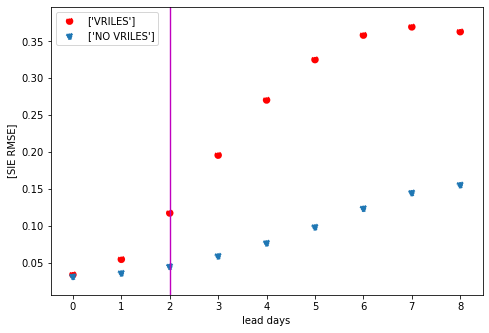

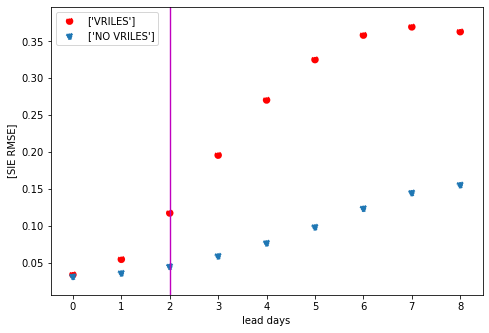

In [333]:
import matplotlib.pyplot as plt
fig1 = plt.figure(1)
ax1 = fig1.add_axes([0,0,1,1])
ax1.axvline(x=VRILE_shift/7,color='m',linewidth=1.4)
foo = SIE_errors.xs('Central Arctic').reset_index()
foo.plot.scatter(x='lead days',y=['SIE RMSE'],linewidth=2,linestyle='--',ax=ax1,color='r',label=['VRILES'],
                s=30)
foo2 = SIE_errors_NO.xs('Central Arctic').reset_index()
foo2.plot.scatter(x='lead days',y=['SIE RMSE'],linewidth=2,linestyle=':',ax=ax1,label=['NO VRILES'],s=30)
foo['SIE RMSE']/foo2['SIE RMSE']

In [334]:
SIE_errors.xs('panArctic')

,SIE RMSE,SIE anom RMSE,SIE MAE,SIE anom MAE
lead days,,,,
0.0,0.565478,0.390695,0.414688,0.326268
1.0,0.825958,0.299141,0.679601,0.244979
2.0,0.935970,0.305223,0.777291,0.241563
3.0,0.979099,0.313899,0.803126,0.237168
4.0,1.016677,0.322938,0.816348,0.240021
5.0,1.048051,0.335014,0.820298,0.254653
6.0,1.087475,0.355501,0.833285,0.269615
7.0,1.122714,0.373426,0.854199,0.281510
8.0,1.145935,0.389515,0.876184,0.296913


,SIE RMSE,SIE anom RMSE,SIE MAE,SIE anom MAE
lead days,,,,
0.0,0.565478,0.390695,0.414688,0.326268
1.0,0.825958,0.299141,0.679601,0.244979
2.0,0.935970,0.305223,0.777291,0.241563
3.0,0.979099,0.313899,0.803126,0.237168
4.0,1.016677,0.322938,0.816348,0.240021
5.0,1.048051,0.335014,0.820298,0.254653
6.0,1.087475,0.355501,0.833285,0.269615
7.0,1.122714,0.373426,0.854199,0.281510
8.0,1.145935,0.389515,0.876184,0.296913


Replace <code>SIE anom RMSE</code> and <code>SIE anom MAE</code> in <code>SIE_errors</code> with corresponding entries from  <code>SIE_anom_errors</code> (and same for raw)

In [335]:
SIE_errors[['SIE anom RMSE','SIE anom MAE']] = SIE_anom_errors[['SIE anom RMSE','SIE anom MAE']]
SIE_raw_err['SIE anom'] = SIE_anom_raw_err['SIE anom']
SIE_errors_NO[['SIE anom RMSE','SIE anom MAE']] = SIE_anom_errors_NO[['SIE anom RMSE','SIE anom MAE']]
#SIE_raw_err_NO[['SIE anom']] = SIE_anom_raw_err_NO['SIE anom']

In [336]:
SIE_errors['type'] = 'VRILE days'
SIE_errors_NO['type'] = 'no VRILE days'
SIE_errors_all = SIE_errors.append(SIE_errors_NO)

Save files!

In [337]:
fdir = '/home/disk/sipn/mcmcgraw/McGraw_etal_2020/code/make_it_nice/data/{model_name}/'.format(model_name=model_name)
fdir = fdir+'OBS_{obs_name}/'.format(obs_name=obs_name)
if lead_weeks == True:
    fdir = fdir+'lead_time_WEEKS/'
if not os.path.exists(fdir):
    os.makedirs(fdir)
fname_save_raw = fdir+"ERROR_PROP_RAW_err_{model_name}_months{seas_str}_VRILE{thresh_str}_offset_"\
"{max_date_offset}days_SHIFT_{VRILE_shift}days_model_clim_freq_{clim_freq_str}.csv".format(model_name=model_name,
                                             seas_str=seas_str,thresh_str=thresh_str,max_date_offset=max_date_offset,
                                             VRILE_shift=VRILE_shift,clim_freq_str=clim_freq_str)
fname_save_RMSE = fdir+"ERROR_PROP_VRILE_vs_NOVRILE_RMSE_MAE_{model_name}_months{seas_str}_offset_"\
"{max_date_offset}days_VRILE{thresh_str}_SHIFT_{VRILE_shift}days_model_clim_freq_{clim_freq_str}.csv".format(model_name=model_name,
                            seas_str=seas_str,thresh_str=thresh_str,max_date_offset=max_date_offset,
                            VRILE_shift=VRILE_shift,clim_freq_str=clim_freq_str)

SIE_raw_err.to_csv(fname_save_raw)
SIE_errors_all.to_csv(fname_save_RMSE)
print('files saved')

files saved
files saved
